## Module 4: BiGANs

(link to paper: https://arxiv.org/abs/1605.09782)

In vanilla GANs, we saw that the generator could generate a wide variety of images, but we had no control over the type of images generated.
In C-GAN and AC-GAN, we saw that we can gain some control over the type of images to be generated.
BiGAN solves the problem of getting the latent variable given an image. This is the inference problem. BiGANs can be used for feature learning. Here is a diagram of BiGAN:

<p><img src="BiGAN.png" alt=""></p>

There are three networks in the BiGAN. The generator network G converts noise input into images. The discriminator network D determines whether the input is real or fake. The encoder network E converts the image back into the latent variable.

In [1]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from itertools import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

mb_size = 64
z_dim = 10
X_dim = 784
y_dim = 10
h_dim = 128
cnt = 0
lr = 1e-3


def log(x):
    return torch.log(x + 1e-8)

setcuda = True

We will use MNIST dataset for this example. This is purely unsupervised, and we do not need to use the labels for this exercise.

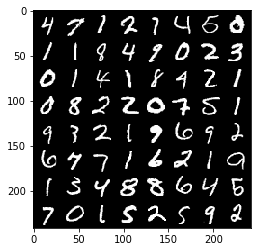

In [2]:
# define a transformation to resize the image to 64x64
import torchvision
import torchvision.transforms as transforms

# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

dataiter = iter(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()

def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

Let us define the three networks, Q(inference network), P(generator network) and D(discriminator network. Note that I am using a class notation for defining Q. This is so that I can get the feature representation if I want. A function getfeature() is defined for this purpose.

We use ADAM solver to train BiGAN

In [3]:
# Inference net (Encoder) Q(z|X)
# Q = torch.nn.Sequential(
#     torch.nn.Linear(X_dim, h_dim),
#     torch.nn.ReLU(),
#     torch.nn.Linear(h_dim, z_dim)
# )

class Q_(torch.nn.Module):
    def __init__(self):
        super(Q_, self).__init__()
        self.layer1 = torch.nn.Linear(X_dim, h_dim)
        self.layer2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Linear(h_dim, z_dim)
    
    def forward(self, x):
        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)
        return l3
    
    def getfeature(self, x):
        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        return l2
Q = Q_()

# Generator net (Decoder) P(X|z)
P = torch.nn.Sequential(
    torch.nn.Linear(z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, X_dim),
    torch.nn.Sigmoid()
)

D_ = torch.nn.Sequential(
    torch.nn.Linear(X_dim + z_dim, h_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(h_dim, 1),
    torch.nn.Sigmoid()
)


def D(X, z):
    return D_(torch.cat([X, z], 1))


def reset_grad():
    Q.zero_grad()
    P.zero_grad()
    D_.zero_grad()

if setcuda:
    Q = Q.cuda()
    P = P.cuda()
    D_ = D_.cuda()

G_solver = optim.Adam(chain(Q.parameters(), P.parameters()), lr=lr)
D_solver = optim.Adam(D_.parameters(), lr=lr)

Let us train the network. The network is trained in two steps.

In the first step, we update the weights of the discriminator. Some real images are passed to the encoder to get the fake latent variables. Some random noise is passed to the generator to get the fake (generated) images. Both of these are passed to the discriminator to get the discriminator loss. This is backpropagated to update the discriminator weight.

A similar thing is done for the generator and encoder weights. Note that they are optimized together using 'chain' in the code above.

In [4]:
dataiter = initialize_loader(trainset)

for it in range(1000):
    # Sample data
    z = Variable(torch.randn(mb_size, z_dim))
    X, _ = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,_ = mnist_next(dataiter)
    X = Variable(torch.from_numpy(X))
    
    if setcuda:
        z = z.cuda()
        X = X.cuda()

    # Discriminator
    z_hat = Q(X)
    X_hat = P(z)

    D_enc = D(X, z_hat)
    D_gen = D(X_hat, z)

    D_loss = -torch.mean(log(D_enc) + log(1 - D_gen))

    D_loss.backward()
    D_solver.step()
    G_solver.step()
    reset_grad()

    # Autoencoder Q, P
    z_hat = Q(X)
    X_hat = P(z)

    D_enc = D(X, z_hat)
    D_gen = D(X_hat, z)

    G_loss = -torch.mean(log(D_gen) + log(1 - D_enc))

    G_loss.backward()
    G_solver.step()
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {:.4}; G_loss: {:.4}'
              .format(it, D_loss.data[0], G_loss.data[0]))
print('Done')

Iter-0; D_loss: 1.401; G_loss: 2.037
Done


Let us see the kind of images produced by the generator network:

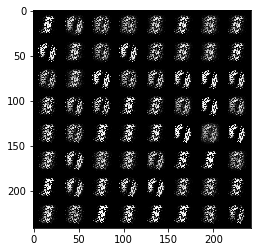

In [5]:
import torchvision

z = Variable(torch.randn(mb_size, z_dim))
if setcuda:
    z = z.cuda()
samples = P(z)
samples = samples.cpu()
img = samples.data
img = img.view([mb_size,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

Let us see how good the encoder is. First we get some samples from the MNIST dataset. Then we pass it through the encoder network to get the latent encoding. We then pass the latent vector to the generator to see if the generator can get the image we started with.

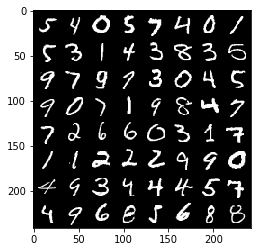

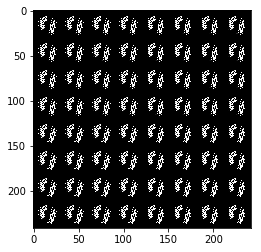

In [6]:
img, _ = mnist_next(dataiter)
img = torch.from_numpy(img)
img1 = img.view(64,1,28,28)
img1 = img1.repeat(1,3,1,1)
img1 = torchvision.utils.make_grid(img1)
img1 = img1.permute(1,2,0)
plt.figure()
plt.imshow(img1.numpy())
if setcuda:
    img = img.cuda()
encodedvariable = Q(Variable(img))
decoded = P(encodedvariable)
decoded = decoded.cpu()
decoded = decoded.data
decoded = decoded.view(64,1,28,28)
decoded = decoded.repeat(1,3,1,1)
decoded = torchvision.utils.make_grid(decoded)
decoded = decoded.permute(1,2,0)

plt.figure()
plt.imshow(decoded.numpy())

The results will get better with more training.

### Questions/Exercises
1. Can you think of a way to gradually transition (morph) between two images using BiGANs?
2. How can BiGAN be helpful in classification?
3. (On your own time) BiGANs can be used to do image arithmetic! (As shown here: https://github.com/soumith/dcgan.torch scroll down to section 'Vector Arithmetic') Train a BiGAN using a face image dataset. How will you do the vector arithmetic?